In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [2]:
#cargamos la imagen a procesar en escala de grises
img = cv2.imread('fft_alfa_pred.png', cv2.IMREAD_GRAYSCALE)
h,w=img.shape
print(h)
print(w)

698
341


In [3]:
#defino funcion para generar el kernel gaussiano
def generate_kernel(k_size, sigma):
    m = k_size//2
    n = k_size//2
    g_kernel = np.zeros((k_size, k_size), np.float32)
    for x in range(-m, m+1):
        for y in range(-n, n+1):
            x1 = 2*np.pi*(sigma**2)
            x2 = np.exp(-(x**2 + y**2)/(2* sigma**2))
            g_kernel[x+m, y+n] = (1/x1)*x2
    return g_kernel
 

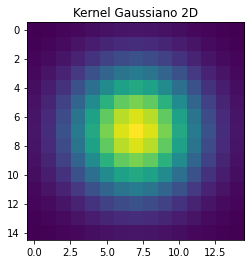

In [4]:
#visualizamos el kernel
k = generate_kernel(15,3)
plt.title("Kernel Gaussiano 2D")
plt.imshow(k)

In [5]:
#funcion para crear el filtro gaussiano con las mismas dimensiones de la imagen a procesar
def create_gauss_filter(h, w, k_size, sigma):
    #llamo a la funcion para generar el kernel
    g_kernel = generate_kernel(k_size, sigma)
    filtro = np.zeros((h,w))
    #obtengo dimensiones del filtro y del kernel
    xfiltro = filtro.shape[1]  
    yfiltro = filtro.shape[0]
    xkernel = g_kernel.shape[1]
    ykernel = g_kernel.shape[0]
    #centro el kernel gaussiano en el filtro
    x_offset=int((xfiltro - xkernel)/2)
    y_offset=int((yfiltro - ykernel)/2)
    filtro[y_offset:y_offset+ykernel, x_offset:x_offset+xkernel] = g_kernel
    #obtengo la transformada
    filtro_ft = np.fft.fft2(filtro)
    return filtro, filtro_ft

(698, 341)


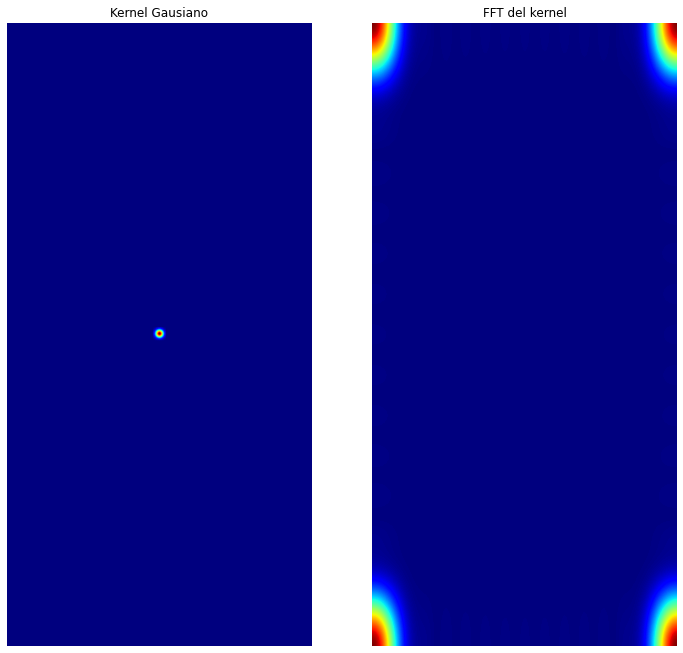

In [6]:
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=3)
print(kernel.shape)
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
plt.imshow(np.abs(kernel_tf), cmap='jet')

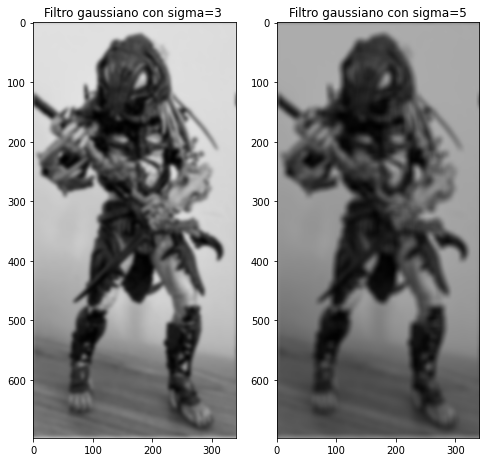

In [42]:
#hacemos el filtrado de la imagen con el filtro creado y probamos con distinto sigma para ver las diferencias. 
#sigma 3
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=3)
img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf
img_gauss = np.real(np.fft.ifft2(np.fft.ifftshift(filtered)))
img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))
#sigma 5
kernel2, kernel_tf2 = create_gauss_filter(h, w, k_size=15, sigma=5)
img_fft2 = np.fft.fft2(img)
filtered2 = img_fft2 * kernel_tf2
img_gauss2 = np.real(np.fft.ifft2(np.fft.ifftshift(filtered2)))
img_gauss2 = np.fft.ifftshift(np.real(np.fft.ifft2(filtered2)))

f = plt.figure(figsize=(8,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.set_title("Filtro gaussiano con sigma=3 ")
ax2.set_title("Filtro gaussiano con sigma=5")
ax.imshow((cv2.cvtColor(np.uint8(img_gauss), cv2.COLOR_BGR2RGB)))
ax2.imshow((cv2.cvtColor(np.uint8(img_gauss2), cv2.COLOR_BGR2RGB)))

Podemos ver que a mayor valor de sigma, mas desenfocada nos queda la imagen. Ahora vamos a hacer una comparación filtrando la imagen utilizando funcion gaussianBlur con los mismos parametros.

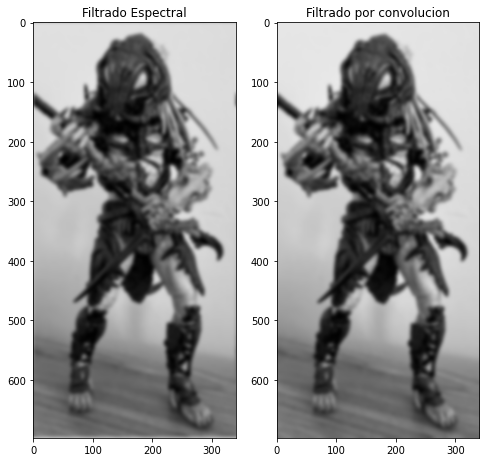

In [39]:
blur=cv2.GaussianBlur(img,(15,15),3)
blur2=cv2.GaussianBlur(img,(15,15),5)
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.set_title("Filtrado Espectral")
ax2.set_title("Filtrado por convolucion")
ax.imshow((cv2.cvtColor(np.uint8(img_gauss), cv2.COLOR_BGR2RGB)))
ax2.imshow((cv2.cvtColor(np.uint8(blur), cv2.COLOR_BGR2RGB)))

Se puede ver que aplicando el mismo tamaño de kernel y mismo sigma las imagenes se ven iguales. 

A continuacion vamos a utilizar el metodo basado en la transformada de fourier descripto en el Paper: Image Sharpness Measure for Blurred Images in Frequency Domain, que lo que busca es medir la calidad de la imagen en funcion de su desenfoque. 

In [12]:
def quality_measure(img):
  m,n=img.shape
  img_fft= np.fft.fft(img)
  img_fft_sh= np.fft.fftshift(img_fft)
  af=np.abs(img_fft_sh)
  M=np.max(af)
  th=M/1000
  cant=len(img_fft[img_fft>th])
  return(cant/(m*n))

In [13]:
fm=quality_measure(img_gauss)
print("filtrado espectral con sigma= 3",fm)
fm=quality_measure(blur)
print("filtrado por convolucion con sigma=3",fm)
fm=quality_measure(img_gauss2)
print("filtrado espectral con sigma= 5",fm)
fm=quality_measure(blur2)
print("filtrado por convolucion con sigma=5",fm)

filtrado espectral con sigma= 3 0.07554890806577653
filtrado por convolucion con sigma=3 0.07420447193069432
filtrado espectral con sigma= 5 0.05956692350998664
filtrado por convolucion con sigma=5 0.058188876471527366


Podemos ver que los resultados para los mismos sigmas son similares con ambos metodos, y como se esperaba al aumentar el sigma, aumenta el desenfoque por lo tanto el resultado de la medicion de la calidad es mas bajo. 

A continuacion se realiza la comparación tomando el metodo STA3 del paper AnalysisOfFocusMeasureOperators.


In [35]:
def STA3(img):
  m,n=img.shape
  mu=np.mean(img)
  Q = np.empty((m, n),dtype='int64')
  for i in range(m):
     for j in range(n):
        Q[i,j]=((img[i,j])-mu)**2
        
  return(Q.sum())


In [36]:
fm=STA3(img_gauss)
print("filtrado espectral con sigma= 3",fm)
fm=STA3(blur)
print("filtrado por convolucion con sigma=3",fm)
fm=STA3(img_gauss2)
print("filtrado espectral con sigma= 5",fm)
fm=STA3(blur2)
print("filtrado por convolucion con sigma=5",fm)

filtrado espectral con sigma= 3 1104988973
filtrado por convolucion con sigma=3 1168870218
filtrado espectral con sigma= 5 629123326
filtrado por convolucion con sigma=5 1125828871


En este caso vemos que los valores obtenidos son similares para sigma= 3 pero si empiezan a ser diferentes cuando aumentamos este valor. Esto tiene sentido ya que si ploteamos las dos imagenes filtradas (filtrado espectral y convolucion) para sigma = 5 Los resultados se empiezan a ver diferentes. 

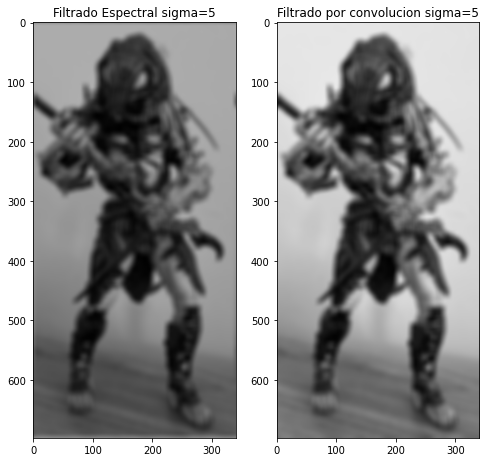

In [40]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.set_title("Filtrado Espectral sigma=5")
ax2.set_title("Filtrado por convolucion sigma=5")
ax.imshow((cv2.cvtColor(np.uint8(img_gauss2), cv2.COLOR_BGR2RGB)))
ax2.imshow((cv2.cvtColor(np.uint8(blur2), cv2.COLOR_BGR2RGB)))